In [1]:
import concurrent.futures
import time
import sys
from dimod import BinaryQuadraticModel
from dwave.system import LeapHybridSampler,EmbeddingComposite,DWaveSampler 
import pandas as pd
import numpy as np
import seaborn as sns
from distance_matrix_creator import *
from neal import neal,SimulatedAnnealingSampler
import matplotlib.pyplot as plt
import dwave.inspector

In [2]:
# np.set_printoptions(suppress=True,threshold= sys.maxsize, linewidth=1000,formatter={'float_kind':'{}'.format, 'all': lambda x: " {:.0f}. ".format(x)})
np.set_printoptions(linewidth=1000, suppress=True,threshold= sys.maxsize)
flow = pd.read_csv("csv_files/flowmatrixbqm.csv", header = None)
flow = (flow.to_numpy()/3)**5
flow = np.round(flow)
flow = np.triu(flow)
flow = np.array(flow)
print(flow,"\n\n")


distance = squaredistmatrix(9)
# distance = np.round(distance,decimals=3)
distance = np.triu(np.array(distance))
distance = (np.array(distance))#**3)/5
distance = np.round(distance,decimals=3)
print(distance)
print(np.shape(distance))


Nfacil = 13
Npos = 81
matrL =9 
positions = []
facilities = [i for i in range(Nfacil)]
positions = [i for i in range(Npos)]

print("Facilities = ", facilities)
print("Positions = ",positions)

facility_size = [10,4,7,4,2,1,14,2,14,3,1,3,2]

[[ 1.31687243e+09  3.20000000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.31687243e+09  3.20000000e+01  3.20000000e+01  3.20000000e+01  1.00000000e+00  1.00000000e+00  4.00000000e+00  0.00000000e+00  4.00000000e+00  4.00000000e+00  1.00000000e+00  4.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.31687243e+09  4.00000000e+00  1.30000000e+01  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31687243e+09  1.00000000e+00  1.30000000e+01  0.00000000e+00  4.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31687243e+09  4.00000000e+00  1.30000000e+01  1.00000000e+00  0.00000000e+00  0.0000000

#Building a variable for each Machine

In [3]:
x = []
for f in facilities:
    x.append([f'F{f}P{p}' for p in positions])
# print(np.array(x))

#Initialise BQM

In [4]:
bqm = BinaryQuadraticModel('BINARY')


#Objective function

In [5]:
for f in range(1,len(facilities)):
    for f1 in range(f+1,len(facilities)):     
        for p in range(len(positions)):
            for p1 in range(p+1,len(positions)):
                bqm.add_quadratic(x[f][p],x[f1][p1],distance[p][p1]*flow[f][f1])

#constraint 1: only 1 machine is placed per position

In [6]:
for p in positions:
    c1 = [(x[f][p],1) for f in facilities]
    bqm.add_linear_inequality_constraint(
        c1,
        ub = 1,
        lb = 0,
        lagrange_multiplier=200,
        label = 'c1_posi_' + str(p),
    )

#Constraint 2: Each facility is given correct size

In [7]:
for f in facilities:
    c2 = [(x[f][p],1) for p in positions]
    bqm.add_linear_equality_constraint(
        c2,
        constant=-1*facility_size[f],
        lagrange_multiplier=300,
        # label = "c2_facil_" + str(f)
    )

Removing 0 bias variables and couplers from BQM

In [8]:
new_bqm = BinaryQuadraticModel(bqm.linear, {interaction: bias for interaction, bias in bqm.quadratic.items() if bias}, bqm.offset, bqm.vartype)
file = open("txt_files/bqm.txt", "w")
file.write(str(bqm))
file.close()

file2 = open("txt_files/new_bqm.txt", "w")
file2.write(str(new_bqm))
file2.close()

#running the solver

In [9]:
def solver(numreads, timelimit,sampler):
    print("running solver")
    
   
    sampleset = sampler.sample(new_bqm, time_limit = timelimit,)
    # sampler = neal.SimulatedAnnealingSampler()
    # sampler = EmbeddingComposite(DWaveSampler())
    # sampleset = sampler.sample(new_bqm,num_reads = numreads)
    
    return sampleset

sampler = LeapHybridSampler()
numreads = 200 #number of samples for simulated annealer
numthreads = 1 #number of parallel annealers to run
timelimit = 10 #time limit for hybrid sampler
samplesets = []

t1 = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:

    results = [executor.submit(solver, numreads,timelimit,sampler) for _ in range(numthreads)]

    for f in concurrent.futures.as_completed(results):
        samplesets.append(f.result())
        

if __name__ == '__solver__':
    solver(numreads,timelimit)

t2 = time.time()
print(f'solver finished in {t2-t1} seconds') 

running solver
solver finished in 23.893806219100952 seconds


Printing Output Solutions

[-376.06800000007206]
{'F0P0': 0, 'F0P1': 0, 'F0P10': 0, 'F0P11': 0, 'F0P12': 0, 'F0P13': 0, 'F0P14': 0, 'F0P15': 0, 'F0P16': 0, 'F0P17': 1, 'F0P18': 0, 'F0P19': 0, 'F0P2': 1, 'F0P20': 0, 'F0P21': 0, 'F0P22': 0, 'F0P23': 0, 'F0P24': 0, 'F0P25': 0, 'F0P26': 0, 'F0P27': 0, 'F0P28': 0, 'F0P29': 0, 'F0P3': 0, 'F0P30': 0, 'F0P31': 0, 'F0P32': 0, 'F0P33': 0, 'F0P34': 0, 'F0P35': 0, 'F0P36': 0, 'F0P37': 0, 'F0P38': 0, 'F0P39': 0, 'F0P4': 0, 'F0P40': 0, 'F0P41': 0, 'F0P42': 1, 'F0P43': 0, 'F0P44': 0, 'F0P45': 0, 'F0P46': 0, 'F0P47': 0, 'F0P48': 0, 'F0P49': 0, 'F0P5': 0, 'F0P50': 0, 'F0P51': 0, 'F0P52': 0, 'F0P53': 0, 'F0P54': 0, 'F0P55': 0, 'F0P56': 0, 'F0P57': 0, 'F0P58': 0, 'F0P59': 0, 'F0P6': 1, 'F0P60': 1, 'F0P61': 0, 'F0P62': 0, 'F0P63': 0, 'F0P64': 0, 'F0P65': 0, 'F0P66': 0, 'F0P67': 1, 'F0P68': 0, 'F0P69': 0, 'F0P7': 0, 'F0P70': 0, 'F0P71': 0, 'F0P72': 0, 'F0P73': 0, 'F0P74': 1, 'F0P75': 1, 'F0P76': 0, 'F0P77': 1, 'F0P78': 0, 'F0P79': 0, 'F0P8': 1, 'F0P80': 0, 'F0P9': 0, 'F10P0': 0, 'F1

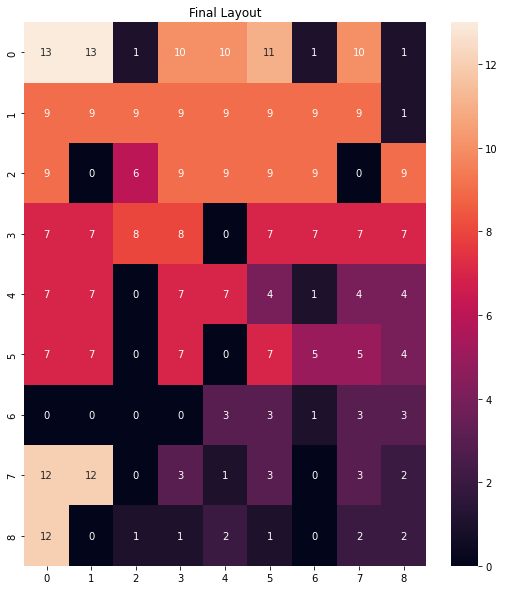

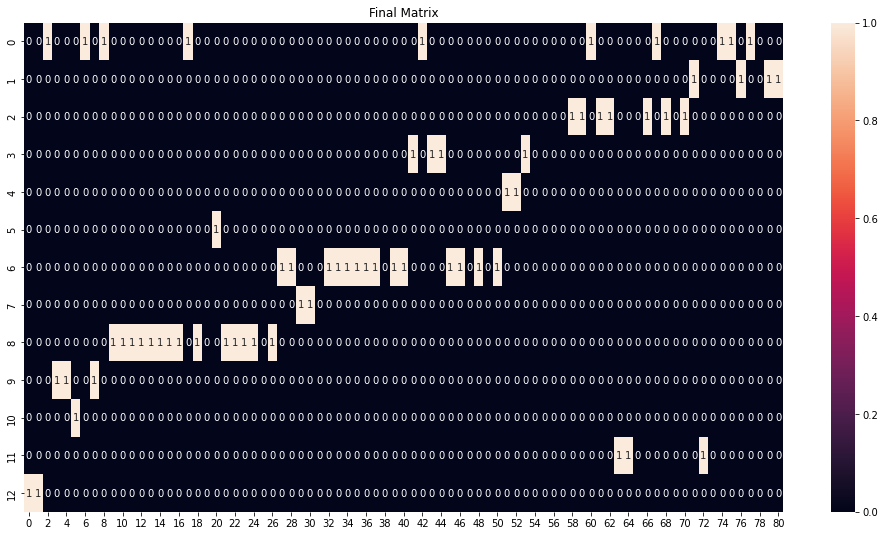

In [10]:
t3 = time.time()

### Extracting best run from all samplesets
energies = [sampleset.first.energy for sampleset in samplesets]
print(energies)
sampleset = samplesets[energies.index(np.min(energies))]
print(sampleset.first.sample)

# dwave.inspector.show_bqm_sampleset(bqm=new_bqm,sampleset=sampleset,sampler=sampler,embedding_context=None,warnings=None,params=None)

### Post Processing the input matrix to convert to a more readable cartesian layout
printout = []
for f in facilities:
    printouttemp = []
    for p in positions:
        label = f'F{f}P{p}'
        value = sampleset.first.sample[label]
        printouttemp.append(value) 
    printout.append(printouttemp)

layout = np.zeros((matrL,matrL))
ctr = 1
for i in printout:
    for j in range(len(i)):
        if i[j] == 1:
            q = int(j/len(layout))
            r = j%len(layout)
            layout[q][r] = ctr
    ctr+=1

### Plotting the Layout using Heatmap
fig, ax = plt.subplots(figsize=(9, 10))
sns.heatmap(layout,annot = layout, vmin = 0, vmax = len(facilities)).set(title = "Final Layout")

### Check to ensure all facilities are assigned correct sizes
correct_size = True
printout = np.array(printout)
for i in range(len(printout)):
    true_size = facility_size[i]
    calc_size = np.sum(printout[i])
    if true_size == calc_size:
        print("Facility ", i+1, "\t correct size of", true_size, "\n")
    else:
        print("Facility ", i+1, "\t wrong size.", "True Size = ", true_size, "Calc size = ", calc_size,"\n")
        correct_size = False
if correct_size == True:
    print("all facilities Correct Size")

### Check to ensure same position is not assigned to two facilities
ctr1 = 0
for i in range(len(printout.T)):
    if np.sum(printout.T[i]) >1:
        print("Position ", i+1, " = Overlapped")
    else:
        ctr1+=1

if ctr1 == 81:
    print("No Overlaps")

fig, ax = plt.subplots(figsize=(17, 9))
sns.heatmap(printout,annot = printout, vmax= 1, vmin=0 ).set(title = "Final Matrix")

t4 = time.time()
print(f'postprocess finished in {t4-t3} seconds') 